2.8.2
2.8.0
Model: "res_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        432       
                                                                 
 sequential (Sequential)     (None, 32, 32, 16)        85248     
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 32)        331712    
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 64)          1317760   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 10)          650       
                                         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:292: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


390/390 [==============================] - 56s 111ms/step - loss: 2.0307 - accuracy: 0.3963 - val_loss: 2.1466 - val_accuracy: 0.4057
Epoch 2/200
390/390 [==============================] - 41s 104ms/step - loss: 1.7284 - accuracy: 0.5151 - val_loss: 3.7576 - val_accuracy: 0.2986
Epoch 3/200
390/390 [==============================] - 41s 104ms/step - loss: 1.3865 - accuracy: 0.6387 - val_loss: 2.1637 - val_accuracy: 0.5167
Epoch 4/200
390/390 [==============================] - 41s 104ms/step - loss: 1.1777 - accuracy: 0.7091 - val_loss: 1.5516 - val_accuracy: 0.6337
Epoch 5/200
390/390 [==============================] - 41s 104ms/step - loss: 1.0609 - accuracy: 0.7455 - val_loss: 1.6171 - val_accuracy: 0.6153
Epoch 6/200
390/390 [==============================] - 41s 104ms/step - loss: 0.9798 - accuracy: 0.7708 - val_loss: 1.2268 - val_accuracy: 0.6949
Epoch 7/200
390/390 [==============================] - 41s 104ms/step - loss: 0.9107 - accuracy: 0.7895 - val_loss: 1.0792 - val_accurac

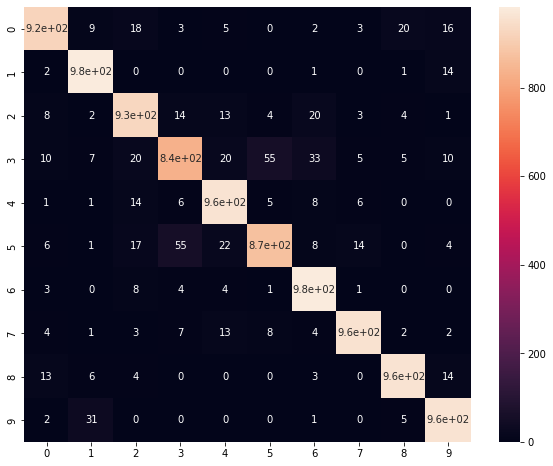

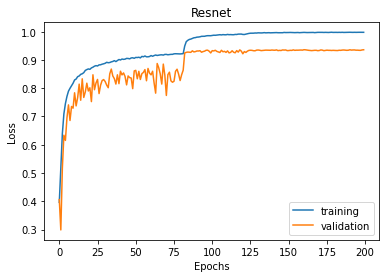

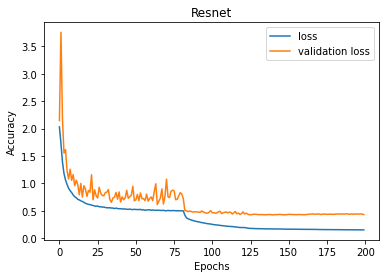

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sb
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models
import datetime

class ResNetModel(keras.Model):
    def __init__(self,
                 num_layers,
                 shortcut_connection=True,
                 weight_decay=1e-4,
                 batch_norm_momentum=0.99,
                 batch_norm_epsilon=1e-3,
                 batch_norm_center=True,
                 batch_norm_scale=True):
        super(ResNetModel, self).__init__()

        if num_layers not in (20, 32, 44, 56, 110):
            raise ValueError('num_layers must be one of 20, 32, 44, 56 or 110.')

        self._num_layers = num_layers
        self._shortcut_connection = shortcut_connection
        self._weight_decay = weight_decay
        self._batch_norm_momentum = batch_norm_momentum
        self._batch_norm_epsilon = batch_norm_epsilon
        self._batch_norm_center = batch_norm_center
        self._batch_norm_scale = batch_norm_scale

        self._num_units = (num_layers - 2) // 6

        self._kernel_regularizer = regularizers.l2(weight_decay)

        self._init_conv = layers.Conv2D(16, 3, 1, 'same', use_bias=False, kernel_regularizer=self._kernel_regularizer)

        self._block1 = models.Sequential([ResNetUnit(
            16,
            1,
            shortcut_connection,
            True if i == 0 else False,
            weight_decay,
            batch_norm_momentum,
            batch_norm_epsilon,
            batch_norm_center,
            batch_norm_scale,
            'res_net_unit_%d' % (i + 1)) for i in range(self._num_units)])

        self._block2 = models.Sequential([ResNetUnit(
            32,
            2 if i == 0 else 1,
            shortcut_connection,
            False if i == 0 else False,
            weight_decay,
            batch_norm_momentum,
            batch_norm_epsilon,
            batch_norm_center,
            batch_norm_scale,
            'res_net_unit_%d' % (i + 1)) for i in range(self._num_units)])

        self._block3 = models.Sequential([ResNetUnit(
            64,
            2 if i == 0 else 1,
            shortcut_connection,
            False if i == 0 else False,
            weight_decay,
            batch_norm_momentum,
            batch_norm_epsilon,
            batch_norm_center,
            batch_norm_scale,
            'res_net_unit_%d' % (i + 1)) for i in range(self._num_units)])

        self._final_bn = layers.BatchNormalization(
            -1,
            batch_norm_momentum,
            batch_norm_epsilon,
            batch_norm_center,
            batch_norm_scale)

        self._final_conv = layers.Conv2D(
            10,
            1,
            1,
            'same',
            use_bias=True,
            kernel_regularizer=self._kernel_regularizer)

        self._softmax = layers.Activation('softmax')

    def build_graph(self, input_shape):
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)

        if not hasattr(self, 'call'):
            raise AttributeError("User should define 'call' method in sub-class model!")

        _ = self.call(inputs)

    def call(self, inputs, training=False):
        net = inputs
        net = self._init_conv(net)

        net = self._block1(net)
        net = self._block2(net)
        net = self._block3(net)

        net = self._final_bn(net)
        net = tf.nn.relu(net)
        net = tf.reduce_mean(net, [1, 2], keepdims=True)
        net = self._final_conv(net)
        net = tf.squeeze(net, axis=[1, 2])
        net = self._softmax(net)

        return net


class ResNetUnit(layers.Layer):
    def __init__(self,
                 depth,
                 stride,
                 shortcut_connection,
                 shortcut_from_preact,
                 weight_decay,
                 batch_norm_momentum,
                 batch_norm_epsilon,
                 batch_norm_center,
                 batch_norm_scale,
                 name):
        super(ResNetUnit, self).__init__(name=name)
        self._depth = depth
        self._stride = stride
        self._shortcut_connection = shortcut_connection
        self._shortcut_from_preact = shortcut_from_preact
        self._weight_decay = weight_decay

        self._kernel_regularizer = regularizers.l2(weight_decay)

        self._bn1 = layers.BatchNormalization(-1,
                                              batch_norm_momentum,
                                              batch_norm_epsilon,
                                              batch_norm_center,
                                              batch_norm_scale,
                                              name='batchnorm_1')
        self._conv1 = layers.Conv2D(depth,
                                    3,
                                    stride,
                                    'same',
                                    use_bias=False,
                                    kernel_regularizer=self._kernel_regularizer,
                                    name='conv1')
        self._bn2 = layers.BatchNormalization(-1,
                                              batch_norm_momentum,
                                              batch_norm_epsilon,
                                              batch_norm_center,
                                              batch_norm_scale,
                                              name='batchnorm_2')
        self._conv2 = layers.Conv2D(depth,
                                    3,
                                    1,
                                    'same',
                                    use_bias=False,
                                    kernel_regularizer=self._kernel_regularizer,
                                    name='conv2')

    def call(self, inputs):
        depth_in = inputs.shape[3]
        depth = self._depth
        preact = tf.nn.relu(self._bn1(inputs))

        shortcut = preact if self._shortcut_from_preact else inputs

        if depth != depth_in:
            shortcut = tf.nn.avg_pool2d(
                shortcut, (2, 2), strides=(1, 2, 2, 1), padding='SAME')
            shortcut = tf.pad(
                shortcut, [[0, 0], [0, 0], [0, 0], [(depth - depth_in) // 2] * 2])

        residual = tf.nn.relu(self._bn2(self._conv1(preact)))
        residual = self._conv2(residual)

        output = residual + shortcut if self._shortcut_connection else residual

        return output
def use_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            print('start with GPU 7')
            tf.config.experimental.set_visible_devices(gpus[7], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[7], True)
        except RuntimeError as e:
            # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
            print(e)


def normalization(train_images, test_images):
    mean = np.mean(train_images, axis=(0, 1, 2, 3))
    std = np.std(train_images, axis=(0, 1, 2, 3))
    train_images = (train_images - mean) / (std + 1e-7)
    test_images = (test_images - mean) / (std + 1e-7)
    return train_images, test_images


def load_images():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)

    (train_images, test_images) = normalization(train_images, test_images)

    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels


def build_optimizer(learning_rate=0.1, momentum=0.9):
    learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [500, 32000, 48000],
        [learning_rate / 10., learning_rate, learning_rate / 10., learning_rate / 100.])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    return optimizer


if __name__ == '__main__':
    print(tf.__version__)
    print(keras.__version__)

    # use_gpu()

    training_epochs = 200
    batch_size = 128
    learning_rate = 0.1
    momentum = 0.9
    weight_decay = 1e-4,
    batch_norm_momentum = 0.99,
    batch_norm_epsilon = 1e-3,
    batch_norm_center = True,
    batch_norm_scale = True
    tf.random.set_seed(777)

    x_train, y_train, x_test, y_test = load_images()

    data_generator = ImageDataGenerator(
        # brightness_range=[.2, .2],
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
    )
    data_generator.fit(x_train)

    # choose model with parameter 20, 32, 44, 56, 110
    #model = ResNetModel(num_layers=20)
    # model = model.ResNetModel(num_layers=32)
    # model = model.ResNetModel(num_layers=44)
    # model = model.ResNetModel(num_layers=56)
    model = ResNetModel(num_layers=110)

    model.build_graph(x_train.shape)
    model.summary()
    optimizer = build_optimizer(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Define the Keras TensorBoard callback.
    history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                        epochs=training_epochs,
                        verbose=1,
                        callbacks=[],
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test))
    y_predict = model.predict(x_test)
    y_test_labels = np.argmax(y_predict, axis=1)
    y_test = np.argmax(y_test, axis=1)
    cm =confusion_matrix(y_test, y_test_labels)
    print("Confusion Matrix\n", cm)
    plt.figure(figsize=(10, 8))
    sb.heatmap(cm, annot=True)
    plt.show()
    plt.plot(history.history["accuracy"], label="training")
    plt.plot(history.history["val_accuracy"], label="validation")
    plt.title("Resnet")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.title("Resnet")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    model.save_weights('cifar10resnet110_custom.h5')

In [ ]:
print(y_predict)

[[1.6992134e-08 1.4929674e-07 3.0987678e-07 ... 7.6929503e-09
  3.9753314e-07 1.2282654e-09]
 [7.2318014e-09 1.5914919e-08 2.6454594e-12 ... 6.0844461e-13
  1.0000000e+00 1.3236970e-10]
 [6.7899259e-06 3.3407074e-01 7.9644762e-09 ... 3.1743596e-08
  6.5926409e-01 6.6579948e-03]
 ...
 [2.4667123e-08 8.4655767e-08 9.1163639e-07 ... 1.4067798e-05
  3.2023657e-08 1.3331972e-07]
 [4.8779324e-08 9.9998963e-01 2.9058504e-07 ... 4.4291248e-08
  5.2371689e-07 5.5681816e-08]
 [6.2680366e-10 7.1685329e-09 9.3483299e-10 ... 1.0000000e+00
  1.1673255e-10 2.4547964e-09]]


In [ ]:
np.save('respred',y_predict)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
